<a href="https://colab.research.google.com/github/Makuo12/GAN/blob/main/learning_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [3]:
from tensorflow.keras.layers import Input,Dense,LeakyReLU,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,os

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
mnist

<module 'tensorflow.keras.datasets.mnist' from '/usr/local/lib/python3.7/dist-packages/tensorflow/keras/datasets/mnist/__init__.py'>

In [6]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [7]:
X_train.shape

(60000, 28, 28)

In [8]:
#map inputs to (-1,+1) for better training

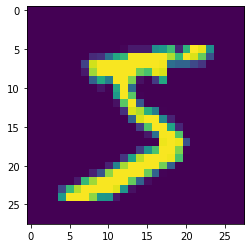

In [12]:
plt.imshow(X_train[0])

In [13]:
X_train,X_test = X_train/255.0 *2-1,X_test/255.0*2-1

In [14]:
N,H,W=X_train.shape

In [16]:
D= H*W

In [17]:
X_train = X_train.reshape(-1,D)
X_test = X_test.reshape(-1,D)

In [18]:
D

784

In [34]:
latent_dim = 100

In [67]:
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256,activation=LeakyReLU(alpha=.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512,activation=LeakyReLU(alpha=.2))(x)
  x = BatchNormalization(momentum=.8)(x)
  x = Dense(1024,activation=LeakyReLU(alpha=.2))(x)
  x = BatchNormalization(momentum=.8)(x)
  x = Dense(D,activation="tanh")(x)

  model = Model(i,x)
  return model

In [28]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512,activation=LeakyReLU(alpha=.2))(i)
  x = Dense(256,activation=LeakyReLU(alpha=.2))(x)
  x = Dense(1,activation="sigmoid")(x)
  model = Model(i,x)
  return model

In [29]:
D

784

In [30]:
discriminator = build_discriminator(D)

In [32]:
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=Adam(.0002,.5),
    metrics=["accuracy"]
)

In [68]:
generator = build_generator(latent_dim)

Because we need to create a combined model so we create new input

In [69]:
z = Input(shape=(latent_dim))

In [70]:
img = generator(z)

In [71]:
discriminator.trainable =False

In [72]:
#Remeber the true ouput is fake, but we label them real

In [73]:
fake_pred = discriminator(img)

In [74]:
combined_model = Model(z,fake_pred)

In [75]:
combined_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_3 (Functional)         (None, 784)               1493520   
_________________________________________________________________
model (Functional)           (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [80]:
combined_model.compile(loss="binary_crossentropy",optimizer=Adam(0.0002,0.5))

In [76]:
batch_size = 32
epochs = 30_000
sample_period = 200 #every "sample_period" steps generate and save some data

In [48]:
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

In [49]:
d_losses = []
g_losses = []

In [50]:
#create a folder to store generated images
if not os.path.exists("gan_images"):
  os.makedirs("gan_images")

In [82]:
def sample_images(epoch):
  rows,cols = 5,5
  noise = np.random.randn(rows*cols,latent_dim)
  imgs = generator.predict(noise)

  #Rescale images 0-1
  imgs = 0.5 *imgs +0.5
  fig,axs  = plt.subplots(rows,cols)
  idx= 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W),cmap="gray")
      axs[i,j].axis("off")
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()
  

In [66]:
X_train[0]

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

In [83]:
#Train Discrimator
for epoch in range(epochs):

  #select a random batch of images
  idx = np.random.randint(0,X_train.shape[0],batch_size)
  real_imgs = X_train[idx]

  #Generate fake images
  noise = np.random.randn(batch_size,latent_dim)
  fake_imgs = generator.predict(noise)

  #Train the discrimator
  #both loss and accuracy are returned
  d_loss_real,d_acc_real = discriminator.train_on_batch(real_imgs,ones)
  d_loss_fake,d_acc_fake = discriminator.train_on_batch(fake_imgs,zeros)
  d_loss = 0.5 * (d_loss_real+d_loss_fake)
  d_acc = 0.5 *(d_acc_real+d_acc_fake)

  #Train Generator
  noise  = np.random.randn(batch_size,latent_dim)
  g_loss = combined_model.train_on_batch(noise,ones)

  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 ==0:
    print(f"epoch:{epoch+1}/{epochs}, \
    d_loss:{d_loss:.2f}, d_acc:{d_acc:.2f}, g-loss:{g_loss:.2f}")
  if epoch % sample_period ==0:
    sample_images(epoch)


epoch:1/30000,     d_loss:0.31, d_acc:0.86, g-loss:0.68
epoch:101/30000,     d_loss:0.04, d_acc:1.00, g-loss:4.26
epoch:201/30000,     d_loss:0.43, d_acc:0.88, g-loss:1.97
epoch:301/30000,     d_loss:0.73, d_acc:0.41, g-loss:0.60
epoch:401/30000,     d_loss:0.72, d_acc:0.44, g-loss:0.63
epoch:501/30000,     d_loss:0.68, d_acc:0.47, g-loss:0.66
epoch:601/30000,     d_loss:0.67, d_acc:0.52, g-loss:0.65
epoch:701/30000,     d_loss:0.68, d_acc:0.45, g-loss:0.69
epoch:801/30000,     d_loss:0.65, d_acc:0.59, g-loss:0.67
epoch:901/30000,     d_loss:0.65, d_acc:0.64, g-loss:0.76
epoch:1001/30000,     d_loss:0.66, d_acc:0.61, g-loss:0.74
epoch:1101/30000,     d_loss:0.66, d_acc:0.64, g-loss:0.71
epoch:1201/30000,     d_loss:0.63, d_acc:0.61, g-loss:0.77
epoch:1301/30000,     d_loss:0.62, d_acc:0.69, g-loss:0.74
epoch:1401/30000,     d_loss:0.61, d_acc:0.70, g-loss:0.82
epoch:1501/30000,     d_loss:0.66, d_acc:0.55, g-loss:0.78
epoch:1601/30000,     d_loss:0.67, d_acc:0.52, g-loss:0.78
epoch:170

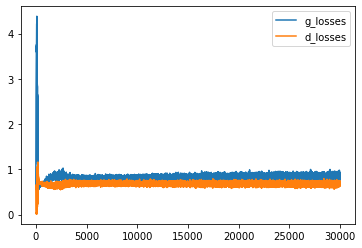

In [84]:
plt.plot(g_losses,label="g_losses")
plt.plot(d_losses,label="d_losses")
plt.legend()